# Solution of 1D Elastodynamics using PINN

Solve the 1D elastodynamics problem:

$\frac{\partial^2 u(t,x)}{\partial t^2} = c^2 \frac{\partial^2 u(t,x)}{\partial x^2} \,\,\, \text{for all} \,\,\, 0< x <4 \,\,\text{and}\,\, 0<t<2$

$u(0,x) = 0 $ 
            
$\frac{\partial u(t,0)}{\partial x} = -\sin(\pi t)\,\,\, \text{for all} \,\, 0\leq t \leq 1 $ 
        
$\frac{\partial u(t,0)}{\partial x} = 0\,\,\, \text{for all} \,\, 1\leq t \leq 2 $ 
            
$\frac{\partial u(0,x)}{\partial t} = 0$ 
            
$u(t,4) = 0 $ 
    
with grid discretization $dx = 0.1$ and physics-informed neural networks.

In [2]:
using NeuralPDE, Flux, ModelingToolkit, GalacticOptim, Optim, DiffEqFlux, CPUTime
import ModelingToolkit: Interval, infimum, supremum

@parameters t,x
@variables u(..)

Dxx = Differential(x)^2
Dtt = Differential(t)^2
Dt = Differential(t)
Dx = Differential(x)

(::Differential) (generic function with 2 methods)

In [3]:
function heaviside(t)
   0.5 * (sign(t) + 1)
end

function interval(t, a, b)
   heaviside(t-a) - heaviside(t-b)
end

function piecewise(t)
   -sin(π*t) * interval(t,0,1) + 0.0 * interval(t, 1,2)
end

piecewise (generic function with 1 method)

In [4]:
#2D PDE
c = 1
eq = Dtt(u(x,t)) ~ c^2*Dxx(u(x,t))


# Domains
domains = [t ∈ IntervalDomain(0.0,2.0), x ∈ IntervalDomain(0.0, 4.0)]

# Initial and Boundary conditions
bcs = [u(0.0,x) ~ 0.0,Dx(u(t,0.0)) ~ piecewise(t),Dt(u(0.0,x)) ~ 0.,u(t,4) ~ 0.0]

4-element Vector{Equation}:
 u(0.0, x) ~ 0.0
 Differential(x)(u(t, 0.0)) ~ -(0.5sign(t) - 0.5sign(t - 1))*sin(πt)
 Differential(t)(u(0.0, x)) ~ 0.0
 u(t, 4) ~ 0.0

In [5]:
dx = 0.1

chain = FastChain(FastDense(2,50,Flux.σ),FastDense(50,50,Flux.σ),
    FastDense(50,50,Flux.σ),FastDense(50,1))
discretization = PhysicsInformedNN(chain, GridTraining(dx))

@named pde_system = PDESystem(eq,bcs,domains,[t,x],[u])
prob = discretize(pde_system,discretization)

cb = function (p,l)
    println("Current loss is: $l")
    return false
end
# optimizer
opt = Optim.BFGS()
@time @CPUtime res = GalacticOptim.solve(prob,opt; cb = cb, maxiters=2200)
phi = discretization.phi

Current loss is: 3.078760395014052
Current loss is: 1.9603777646456193
Current loss is: 0.29391475149163115
Current loss is: 0.23418507263580327
Current loss is: 0.23208403702161834
Current loss is: 0.21290270867438355
Current loss is: 0.20763616768862608
Current loss is: 0.20721307663835084
Current loss is: 0.2017347241731096
Current loss is: 0.19737582659075717
Current loss is: 0.18644704881534802
Current loss is: 0.17845645557960121
Current loss is: 0.1755203011009766
Current loss is: 0.17413230693612855
Current loss is: 0.17193542752883872
Current loss is: 0.1612532277337122
Current loss is: 0.1593633632301862
Current loss is: 0.14318128671931124
Current loss is: 0.1408355797359376
Current loss is: 0.1371304065345615
Current loss is: 0.13008849970949538
Current loss is: 0.12295857772716894
Current loss is: 0.12047804910088833
Current loss is: 0.11700854776565162
Current loss is: 0.11106144362291655
Current loss is: 0.10534542471881887
Current loss is: 0.10291374841611144
Current lo

#298 (generic function with 1 method)

In [6]:
function analytic(t,x,ch = "dis")
   if (x<c*(t-1))
        if(ch=="dis")
            return 2*c/π
        else
            return 0.0
        end
    elseif(x<=c*t)
        if (ch=="dis")
            return (1-cos(π*(t-(x/c))))*(c/π)
        else
            return c*sin(π*(t-(x/c)))
        end
    else
        return 0.0
    end
end

analytic (generic function with 2 methods)

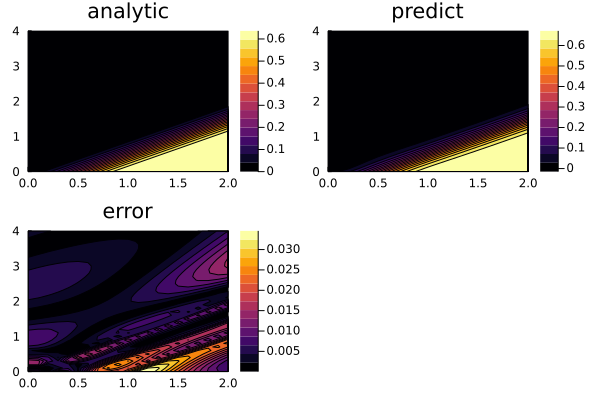

In [10]:
using Plots

ts,xs = [infimum(d.domain):dx:supremum(d.domain) for d in domains]

u_predict = reshape([first(phi([t,x],res.minimizer)) for t in ts for x in xs],(length(xs),length(ts)))
u_real = reshape([analytic(t,x,"dis") for t in ts for x in xs], (length(xs),length(ts)))

diff_u = abs.(u_predict .- u_real)
p1 = plot(ts, xs, u_real, linetype=:contourf,title = "analytic");
savefig("analyticWave1D.pdf")
p2 = plot(ts, xs, u_predict, linetype=:contourf,title = "predict");
savefig("NNWave1D.pdf")
p3 = plot(ts, xs, diff_u,linetype=:contourf,title = "error");
savefig("errorWave1D.pdf")
plot(p1,p2,p3)